<a href="https://colab.research.google.com/github/dustin-kang/Proj2_SoccerPlayer-Machine-Learning/blob/main/Report/6_Hyperparameter_Tuning_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter_Tuning_Classifier

파라미터 최적화를 통해 더 좋은 성능을 내기 위해 모델을 조정한다.


<aside>

### **💡 4) 머신러닝 방식 적용 및 교차검증**

데이터의 탐색과 전처리 작업이 끝났다면 **모델링을 통해 베이스라인과의 성능 비교**를 해봅니다.

- Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)
- 평가지표를 계산 후 베이스라인과 비교해보세요.
- 어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.
- 모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.
    - Hyperparameter tuning, etc.
- 최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.
- 최종 모델의 test 점수를 보고하세요.

### **태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.**

1. 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
2. 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
3. 최종 모델에 관해 설명하세요.
</aside>

In [11]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 전체 컬럼 출력하기
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

df4 = pd.read_csv('../data/cls_data_4p.csv')
df11 = pd.read_csv('../data/cls_data_11p.csv')

## 1. Train, Test, Split

In [12]:
from sklearn.model_selection import train_test_split 

target = 'position'
train, test = train_test_split(df11, random_state=2, train_size=.75, stratify=df11[target])
train, val = train_test_split(train, random_state=2, train_size=.75, stratify=train[target])
train.shape, val.shape, test.shape

((10656, 103), (3552, 103), (4736, 103))

In [13]:
features = train.columns.drop(target)
# X (features)
X_train = train[features] 
X_val = val[features]
X_test = test[features]

# y (Target)
y_train = train[target]
y_val = val[target] 
y_test = test[target]

## pre-OneHot Encoding

In [14]:
# preprocessing

from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Classifier Model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, f1_score, accuracy_score

# Model Selection, Parameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [15]:
enc = OneHotEncoder(cols = [
                            'preferred_foot',
                            'body_type'
], use_cat_names=True)

enc_train = enc.fit_transform(X_train)
train_features_transform = enc_train.columns # 인코딩이 완료된 특성을 변수에 담기

enc_val = enc.transform(X_val)
enc_test = enc.transform(X_test)


## RandomizedSearchCV
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221574025920

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(50, 500),
  'randomforestclassifier__max_depth' : [5, 10, 15, 20, None],
  'randomforestclassifier__min_samples_leaf' : [5, 10, 15, 20, None],
  'randomforestclassifier__min_samples_split' : [5, 15, 30, 40, None]
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 244, in fit
    if not 0. < self.min_samples_split <= 1.:
TypeError: '<' not supported between instances of 'float' and 'NoneType'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", li

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 244, in fit
    if not 0. < self.min_samples_split <= 1.:
TypeError: '<' not supported between instances of 'float' and 'NoneType'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", li

  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 244, in fit
    if not 0. < self.min_samples_split <= 1.:
TypeError: '<' not supported between instances of 'float' and 'NoneType'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", li

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 169, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 230, in fit
    if not 0. < self.min_samples_leaf <= 0.5:
TypeError: '<' not supported between instances of 'float' and 'NoneType'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", li

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/dongwoo/opt/anaconda3/lib/python3.9/site-pac

In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__min_samples_leaf': 10,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 364}

In [ ]:
clf.best_score_

0.6241554054054054

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,44,22,24,5,13,30,15,2,12,32,36,43,18,8,34,23,48,21,46,38,37,11,14,19,47,4,41,27,3,31,7,42,0,16,9,39,10,28,17,45,26,1,6,33,40,20,25,35,29,49
mean_fit_time,9.32017,10.4816,10.0879,2.68978,6.68378,3.0227,5.69911,11.9217,10.6224,4.68195,9.33896,9.91279,10.1491,8.25108,7.04245,7.07157,5.8223,6.29758,8.0006,3.09409,2.05176,3.47517,7.40652,4.14592,9.13552,10.4922,10.4429,8.23909,3.6941,4.51717,4.28011,2.80048,2.42887,3.01558,3.81117,4.99078,3.21954,5.25393,3.13836,2.71005,5.97493,0.328686,0.436648,0.286005,0.199055,0.335325,0.307028,0.383347,0.191591,0.472464
std_fit_time,0.0182289,0.064868,0.031706,0.0146131,0.0330543,0.0146233,0.0296272,0.00750446,0.0473906,0.0167839,0.0387515,0.0999957,0.0288036,0.0650509,0.0559441,0.0369624,0.184531,0.0262045,0.0216634,0.0121301,0.0191769,0.0273895,0.0434095,0.0123767,0.0497908,0.0488978,0.0165572,0.051213,0.0286043,0.0175095,0.0350016,0.00887435,0.0253234,0.00484091,0.0763371,0.00637397,0.0208068,0.0474173,0.00642749,0.0142144,0.0424741,0.0173681,0.00162064,0.00638194,0.00194071,0.00549608,0.00318815,0.00876454,0.0058945,0.00185554
mean_score_time,0.402855,0.447568,0.453286,0.131048,0.293526,0.152577,0.261689,0.519085,0.473711,0.210677,0.411727,0.474261,0.479905,0.385507,0.321025,0.334438,0.252082,0.300134,0.378688,0.156718,0.115655,0.181019,0.341273,0.210156,0.420435,0.492931,0.488936,0.381849,0.193574,0.220612,0.207779,0.151772,0.134856,0.182642,0.225396,0.292744,0.197628,0.332501,0.189945,0.166503,0.348726,0,0,0,0,0,0,0,0,0
std_score_time,0.00958507,0.0148484,0.00949671,0.000953858,0.000906298,0.00467288,0.0149372,0.00774724,0.00818787,0.00234673,0.00733455,0.00840709,0.0261106,0.0117137,0.00237038,0.0128218,0.0326331,0.0111404,0.0056986,0.00392119,0.000792367,0.00979773,0.00726039,0.00539323,0.00630976,0.00120182,0.0159747,0.00668251,0.00226037,9.8295e-05,0.00256011,0.0029627,0.00357535,0.00159048,0.00641981,0.00218566,0.00451263,0.0141839,0.00125851,0.00420358,0.00728397,0,0,0,0,0,0,0,0,0
param_randomforestclassifier__max_depth,20,None,15,20,None,20,20,15,15,20,None,20,20,20,20,10,15,20,20,None,20,10,10,None,None,15,10,10,None,10,10,20,10,5,5,5,5,5,5,5,5,20,10,20,10,20,10,None,5,20
param_randomforestclassifier__min_samples_leaf,10,5,10,5,5,10,5,10,10,5,10,15,15,15,10,5,15,15,20,15,15,5,10,15,20,20,15,15,20,15,10,20,20,15,10,5,10,10,10,5,20,None,15,10,15,None,None,15,None,None
param_randomforestclassifier__min_samples_split,5,5,15,5,30,5,40,30,30,40,30,30,30,5,40,15,30,15,15,15,30,30,40,30,40,30,15,5,40,40,5,5,30,15,15,15,5,30,30,5,5,30,None,None,None,None,40,None,5,30
param_randomforestclassifier__n_estimators,364,356,408,87,256,118,232,490,443,192,395,428,441,355,305,310,251,274,358,130,86,154,346,177,413,481,498,399,165,214,189,127,110,229,289,384,245,416,239,196,473,275,428,222,92,290,260,360,62,476
params,"{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'rand

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.2min finished


                 precision    recall  f1-score   support

 central_attack       0.69      0.94      0.80       430
central_defence       0.58      0.77      0.66       356
 central_middle       0.53      0.77      0.63       466
 defence_middle       0.47      0.56      0.51       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.46      0.05      0.09       124
   left_defence       0.77      0.60      0.68       408
    left_middle       0.29      0.23      0.26       334
   right_attack       0.33      0.01      0.02       130
  right_defence       0.64      0.68      0.66       397
   right_middle       0.33      0.18      0.23       328

       accuracy                           0.62      3552
      macro avg       0.55      0.53      0.50      3552
   weighted avg       0.59      0.62      0.58      3552



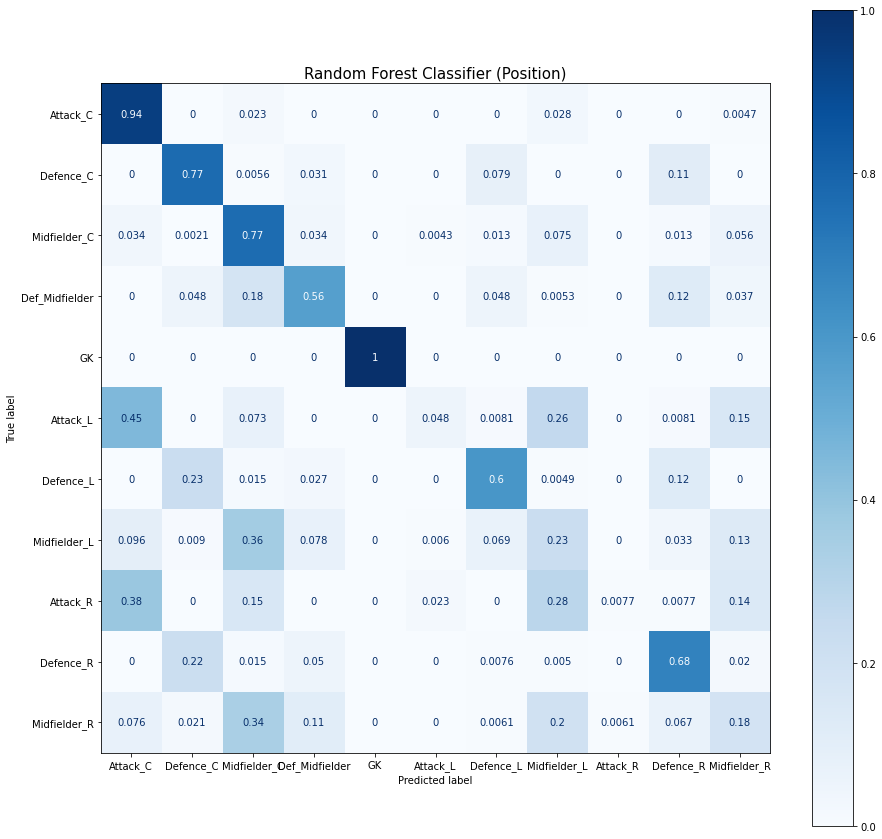

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(50, 500),
  'randomforestclassifier__max_depth' : randint(10,25),
  'randomforestclassifier__min_samples_leaf' : randint(5,10),
  'randomforestclassifier__min_samples_split' : [5, 10, 15]
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 19,
 'randomforestclassifier__min_samples_leaf': 6,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__n_estimators': 390}

In [ ]:
clf.best_score_

0.6260322822822824

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,26,9,20,40,25,16,29,17,24,39,15,7,13,0,5,48,3,23,14,19,41,47,28,32,30,49,18,11,33,34,36,1,43,38,35,8,22,42,31,27,21,37,44,46,2,10,12,4,45,6
mean_fit_time,11.0874,10.7114,11.1516,10.9055,6.75685,12.5609,11.2231,4.74085,4.51666,4.98717,9.40604,4.10605,11.3677,8.40812,6.53822,4.43683,11.5641,13.1973,5.9665,5.99313,10.7406,2.60163,5.20972,4.88439,12.0269,7.3066,10.948,2.04357,8.65768,3.50224,9.81156,5.75204,2.11343,6.00992,9.41772,9.36292,3.17128,8.51455,3.22296,2.71764,3.9803,3.72532,11.9176,1.84082,1.71672,6.63331,9.487,1.88003,4.34616,5.92492
std_fit_time,0.0346605,0.04678,0.0189116,0.0268802,0.0210846,0.0218162,0.10506,0.0336204,0.016525,0.00578178,0.0665417,0.0275243,0.0263444,0.043321,0.0186316,0.0100748,0.00922767,0.0728162,0.0140749,0.0823135,0.0323256,0.00336449,0.0367129,0.0323255,0.0938317,0.71419,0.0788039,0.0189608,0.0409921,0.0110845,0.0938002,0.0126145,0.0172146,0.0286616,0.0944627,0.05478,0.0255931,0.00734081,0.00687755,0.0132845,0.0127039,0.020381,0.00703271,0.0113381,0.0132544,0.0295204,0.0915842,0.0212025,0.0630797,0.0762507
mean_score_time,0.459324,0.458321,0.478736,0.466687,0.301479,0.523345,0.478649,0.23196,0.208487,0.241369,0.403027,0.194267,0.478196,0.374568,0.291753,0.206048,0.486032,0.593272,0.272018,0.265161,0.486523,0.135462,0.241546,0.224631,0.518557,0.3077,0.471544,0.109121,0.370541,0.168064,0.426736,0.255187,0.113622,0.279474,0.405383,0.408595,0.16637,0.38323,0.158651,0.134775,0.185457,0.181795,0.530716,0.103478,0.0982484,0.299448,0.418492,0.103357,0.204976,0.284121
std_score_time,0.00728638,0.0084745,0.0100289,0.00952544,0.00745354,0.0029027,0.00780757,0.000322528,0.00121983,0.00945901,0.00725337,0.00237612,0.00412685,0.00520152,0.00366294,0.00866213,0.00308081,0.0362819,0.00091376,0.00434258,0.0090303,0.00274235,0.00379978,0.00634835,0.00959806,0.042191,0.000918195,0.00237618,0.00564334,0.00013505,0.00248295,0.00497731,0.00148036,0.0113155,0.00813414,0.0113215,0.00677944,0.0163483,0.00434628,0.00155838,0.00263848,0.00644545,0.0101337,0.00105299,0.00183866,0.00318171,0.00546096,0.00125645,0.00211456,0.00869428
param_randomforestclassifier__max_depth,19,20,21,24,14,19,13,19,21,23,24,17,21,24,22,17,20,19,17,21,20,12,15,16,21,20,18,16,21,20,15,16,18,14,12,15,19,13,12,13,21,14,11,13,12,10,10,14,10,10
param_randomforestclassifier__min_samples_leaf,6,7,7,5,5,5,6,7,7,9,8,9,6,8,7,5,6,8,8,7,9,8,8,7,9,5,8,6,5,9,9,6,8,9,6,8,9,8,9,8,8,9,9,8,7,6,6,9,8,8
param_randomforestclassifier__min_samples_split,10,5,10,15,5,10,10,10,5,10,10,5,15,5,5,5,15,5,5,15,15,5,15,15,15,5,10,10,10,5,15,15,15,15,10,10,15,15,10,5,15,10,5,10,10,15,10,10,10,5
param_randomforestclassifier__n_estimators,390,394,403,371,240,426,418,170,158,187,355,155,412,311,239,146,417,489,223,216,398,99,195,177,465,261,413,71,287,130,380,206,73,229,359,352,118,319,127,102,144,139,491,65,63,292,415,70,185,260
params,"{'randomforestclassifier__max_depth': 19, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 24, 'ran...","{'randomforestclassifier__max_depth': 14, 'ran...","{'randomforestclassifier__max_depth': 19, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 19, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 23, 'ran...","{'randomforestclassifier__max_depth': 24, 'ran...","{'randomforestclassifier__max_depth': 17, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 24, 'ran...","{'randomforestclassifier__max_depth': 22, 'ran...","{'randomforestclassifier__max_depth': 17, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 19, 'ran...","{'randomforestclassifier__max_depth': 17, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestcl

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 15.2min finished


                 precision    recall  f1-score   support

 central_attack       0.69      0.94      0.80       430
central_defence       0.58      0.76      0.66       356
 central_middle       0.53      0.77      0.63       466
 defence_middle       0.47      0.57      0.52       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.50      0.06      0.10       124
   left_defence       0.78      0.60      0.68       408
    left_middle       0.32      0.24      0.27       334
   right_attack       0.25      0.01      0.01       130
  right_defence       0.64      0.68      0.66       397
   right_middle       0.33      0.18      0.24       328

       accuracy                           0.62      3552
      macro avg       0.55      0.53      0.51      3552
   weighted avg       0.59      0.62      0.59      3552



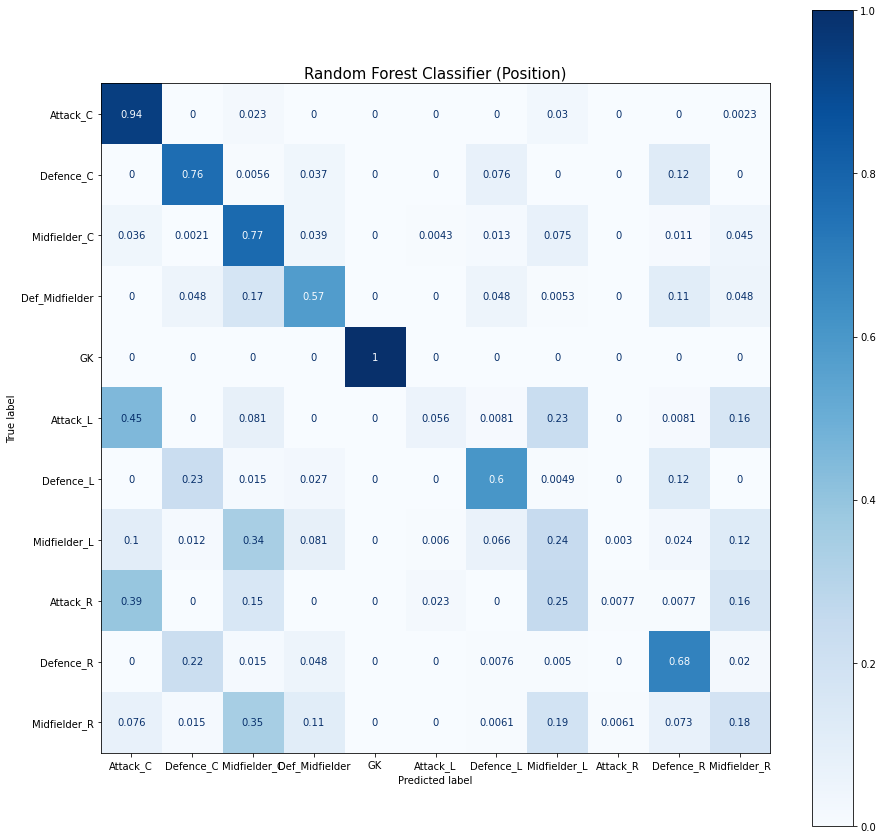

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(370, 430),
  'randomforestclassifier__max_depth' : randint(14,24),
  'randomforestclassifier__min_samples_leaf' : randint(5,10),
  'randomforestclassifier__min_samples_split' : randint(5, 10)
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
clf.best_score_

0.626783033033033

In [ ]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['preferred_foot', 'body_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclas...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                              

In [ ]:
model = clf.best_estimator_

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,22,12,1,15,34,38,33,32,28,30,6,24,20,39,41,21,36,10,18,9,13,7,2,27,3,49,37,17,0,14,4,43,45,31,16,40,46,42,25,48,29,8,23,47,5,11,26,35,19,44
mean_fit_time,11.3813,11.5544,11.8243,13.0405,11.4478,11.7774,12.4956,12.3793,11.2246,11.7655,11.8077,11.2579,11.3018,13.1868,12.9433,11.7541,12.6769,12.2198,11.4052,12.1954,12.9814,11.5425,12.1803,10.7057,11.1487,11.3162,10.912,13.0839,11.0612,11.7084,11.7809,10.9202,11.3204,13.1402,11.2792,11.8504,11.606,10.4747,11.7676,11.188,11.4875,10.4942,11.3431,10.6226,10.7774,10.535,10.6741,10.6108,10.4992,10.4616
std_fit_time,0.0776593,0.0175256,0.0521958,0.0457742,0.0451362,0.0593026,0.0173707,0.0356462,0.0571644,0.0613335,0.0860716,0.139693,0.0274341,0.0139363,0.113573,0.135852,0.0565799,0.0244392,0.0832956,0.0201754,0.0213185,0.0454633,0.00732594,0.0865552,0.00981963,1.32052,0.00836432,0.0172094,0.0659929,0.00819063,0.0277298,0.254223,0.0242195,0.0440432,0.019811,0.0540809,0.0469408,0.00859519,0.0232706,0.0462967,0.0147569,0.117912,0.110577,0.0257975,0.0697868,0.0644214,0.0112091,0.0526586,0.147017,0.021817
mean_score_time,0.470646,0.505961,0.503036,0.568807,0.500186,0.494004,0.540154,0.530286,0.488099,0.514304,0.497173,0.494219,0.476813,0.552011,0.543578,0.491591,0.535893,0.614623,0.494796,0.512941,0.561419,0.509618,0.546611,0.471014,0.534593,0.46498,0.464775,0.574365,0.516223,0.56251,0.54245,0.458764,0.495894,0.572094,0.499988,0.544241,0.498559,0.446745,0.509638,0.473474,0.487457,0.453134,0.500351,0.471641,0.477249,0.493755,0.481336,0.47151,0.466473,0.453232
std_score_time,0.00558726,0.0156012,0.00224042,0.0139487,0.0119985,0.00676596,0.00811217,0.00426946,0.00728728,0.012917,0.00674151,0.0191955,0.0012287,0.0142611,0.0112432,0.010783,0.0150489,0.0729833,0.00455358,0.0108667,0.0053468,0.015088,0.0233123,0.00621128,0.00695468,0.0601625,0.000775825,0.0155717,0.0219835,0.00351927,0.0197583,0.00553324,0.012501,0.0183877,0.00631267,0.0710871,0.00322609,0.00241068,0.00758927,0.0053744,0.0025902,0.00945161,0.0150569,0.00168723,0.00731,0.0134292,0.0193832,0.00257917,0.0116289,0.00318379
param_randomforestclassifier__max_depth,20,16,23,15,22,23,20,21,16,17,20,16,17,21,22,21,18,21,14,18,21,16,15,21,16,20,23,16,19,14,19,20,15,20,20,14,14,16,20,19,15,14,16,22,16,16,23,19,19,14
param_randomforestclassifier__min_samples_leaf,6,6,6,5,6,7,7,6,7,6,7,7,6,5,6,5,6,5,5,6,6,8,6,8,8,5,8,5,8,7,9,8,9,5,8,6,7,8,8,8,6,7,9,9,9,9,9,9,9,8
param_randomforestclassifier__min_samples_split,9,5,8,6,7,8,9,8,7,9,9,8,6,6,8,7,5,5,8,8,6,5,7,8,6,7,5,5,7,6,9,9,9,8,8,7,9,6,5,8,5,9,6,5,5,9,7,9,7,6
param_randomforestclassifier__n_estimators,391,382,389,416,378,407,426,406,383,387,406,395,380,426,424,384,419,386,373,414,426,416,409,373,393,390,386,416,387,406,423,382,415,412,393,413,409,372,413,396,383,376,417,386,390,378,383,381,378,377
params,"{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 23, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 22, 'ran...","{'randomforestclassifier__max_depth': 23, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 17, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 17, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 22, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 18, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 14, 'ran...","{'randomforestclassifier__max_depth': 18, 'ran...","{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestcla

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

훈련 f1 score (micro):  0.8487237237237237
검증 f1 score (micro):  0.620213963963964
훈련 f1 score (macro):  0.8110101411704569
검증 f1 score (macro):  0.5061191618636856


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


                 precision    recall  f1-score   support

 central_attack       0.69      0.94      0.80       430
central_defence       0.57      0.78      0.66       356
 central_middle       0.53      0.77      0.63       466
 defence_middle       0.47      0.57      0.52       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.43      0.05      0.09       124
   left_defence       0.78      0.60      0.68       408
    left_middle       0.32      0.25      0.28       334
   right_attack       0.33      0.01      0.02       130
  right_defence       0.65      0.68      0.66       397
   right_middle       0.33      0.17      0.23       328

       accuracy                           0.62      3552
      macro avg       0.55      0.53      0.51      3552
   weighted avg       0.60      0.62      0.59      3552



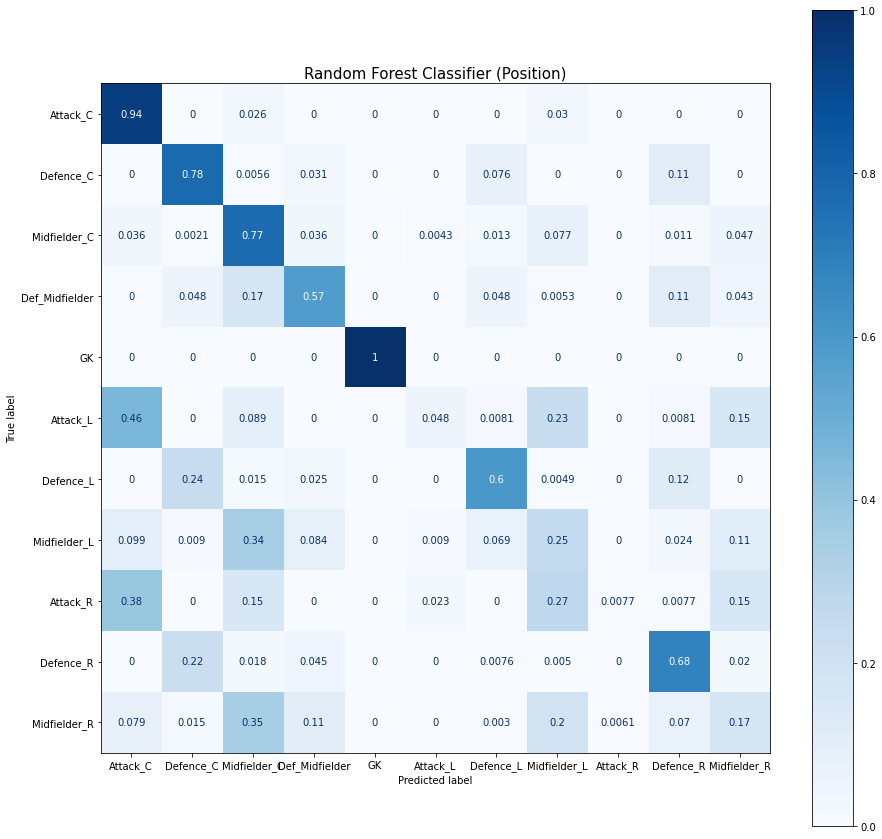

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(380, 410),
  'randomforestclassifier__max_depth' : randint(18,24),
  'randomforestclassifier__min_samples_leaf' : [5,6],
  'randomforestclassifier__min_samples_split' : randint(5, 10)
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

훈련 f1 score (micro):  0.8494744744744744
검증 f1 score (micro):  0.6204954954954955
훈련 f1 score (macro):  0.8113439631293979
검증 f1 score (macro):  0.5050757682520356


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,1,6,7,0,3,9,5,8,2,4
mean_fit_time,11.7204,11.3441,11.4533,12.1259,12.3381,12.2004,12.1005,10.9993,12.5259,12.0497
std_fit_time,0.0329341,0.0783367,0.122166,0.038956,0.0571649,0.232459,0.175115,0.0518954,0.0333408,0.106309
mean_score_time,0.519712,0.474494,0.483564,0.533001,0.550646,0.540135,0.490271,0.512415,0.555951,0.513955
std_score_time,0.0246435,0.0128297,0.000790698,0.015071,0.0122401,0.135207,0.00419341,0.0569285,0.0310961,0.0281385
param_randomforestclassifier__max_depth,21,20,23,18,18,20,23,18,22,20
param_randomforestclassifier__min_samples_leaf,6,6,6,5,5,5,5,6,5,5
param_randomforestclassifier__min_samples_split,8,7,7,7,8,8,7,5,6,5
param_randomforestclassifier__n_estimators,388,396,405,384,394,393,401,390,399,388
params,"{'randomforestclassifier__max_depth': 21, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 23, 'ran...","{'randomforestclassifier__max_depth': 18, 'ran...","{'randomforestclassifier__max_depth': 18, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 23, 'ran...","{'randomforestclassifier__max_depth': 18, 'ran...","{'randomforestclassifier__max_depth': 22, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran..."
split0_test_score,0.631757,0.63232,0.632601,0.631194,0.63232,0.629223,0.63232,0.628378,0.628941,0.628378


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.2s finished


                 precision    recall  f1-score   support

 central_attack       0.67      0.96      0.79       430
central_defence       0.56      0.77      0.65       356
 central_middle       0.53      0.80      0.64       466
 defence_middle       0.48      0.54      0.51       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.31      0.03      0.06       124
   left_defence       0.79      0.60      0.68       408
    left_middle       0.32      0.24      0.28       334
   right_attack       0.00      0.00      0.00       130
  right_defence       0.62      0.67      0.65       397
   right_middle       0.34      0.17      0.23       328

       accuracy                           0.62      3552
      macro avg       0.51      0.52      0.50      3552
   weighted avg       0.58      0.62      0.58      3552



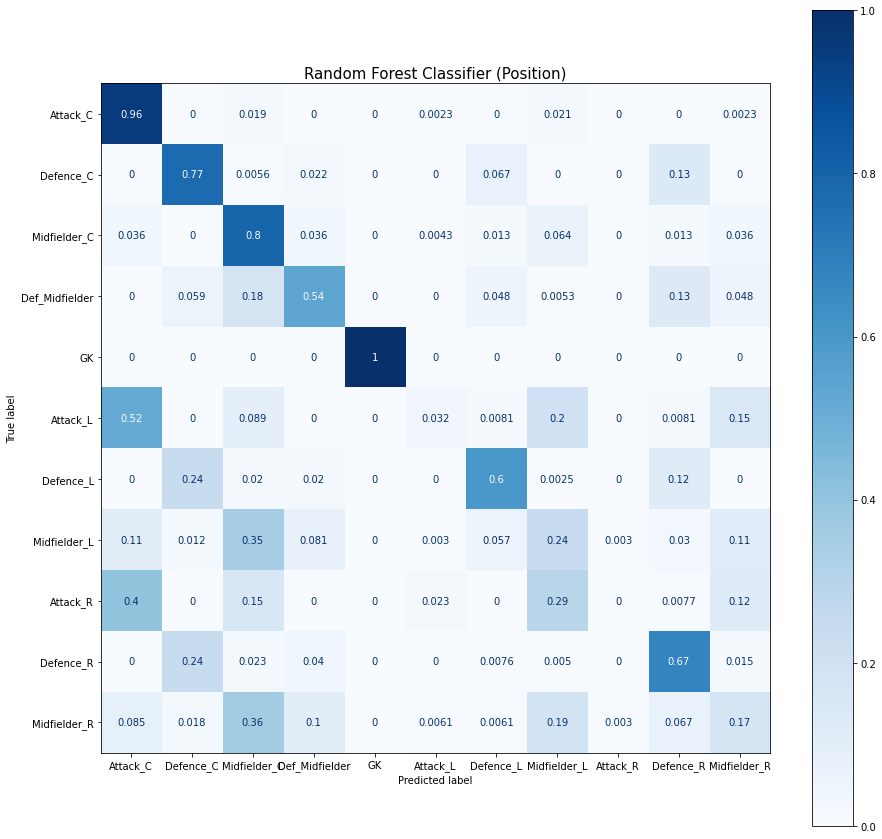

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(100, 300),
  'randomforestclassifier__max_depth' : randint(10,21),
  'randomforestclassifier__min_samples_leaf' : [5,6],
  'randomforestclassifier__min_samples_split' : randint(5, 10),
  'randomforestclassifier__max_features' : randint(3,5)
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

훈련 f1 score (micro):  0.8097785285285285
검증 f1 score (micro):  0.6188063063063063
훈련 f1 score (macro):  0.7506388697664067
검증 f1 score (macro):  0.4976411598300281


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,4,5,7,8,1,9,2,3,6,0
mean_fit_time,2.49674,2.19979,2.10664,2.02419,4.08703,2.17815,2.84582,1.44244,1.73757,1.50839
std_fit_time,0.0187739,0.0143617,0.0141419,0.00713324,0.0323015,0.223698,0.0230827,0.0311239,0.0141459,0.00824634
mean_score_time,0.216349,0.198773,0.221727,0.184578,0.340068,0.219396,0.295066,0.136258,0.19733,0.164824
std_score_time,0.00126563,0.00683342,0.00812812,0.00476492,0.0068965,0.0264981,0.0106811,0.00112207,0.00182581,0.00107309
param_randomforestclassifier__max_depth,16,15,13,14,13,16,13,12,11,11
param_randomforestclassifier__max_features,4,4,3,4,4,3,3,4,3,3
param_randomforestclassifier__min_samples_leaf,6,6,5,6,6,6,6,5,5,5
param_randomforestclassifier__min_samples_split,9,8,5,7,5,9,9,7,7,6
param_randomforestclassifier__n_estimators,171,148,174,139,294,187,243,100,156,133
params,"{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 14, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 16, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 11, 'ran...","{'randomforestclassifier__max_depth': 11, 'ran..."


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.6s finished


                 precision    recall  f1-score   support

 central_attack       0.68      0.95      0.79       430
central_defence       0.57      0.77      0.65       356
 central_middle       0.53      0.78      0.63       466
 defence_middle       0.47      0.54      0.50       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.45      0.04      0.07       124
   left_defence       0.79      0.60      0.68       408
    left_middle       0.32      0.27      0.30       334
   right_attack       0.00      0.00      0.00       130
  right_defence       0.61      0.68      0.64       397
   right_middle       0.38      0.16      0.23       328

       accuracy                           0.62      3552
      macro avg       0.53      0.53      0.50      3552
   weighted avg       0.58      0.62      0.58      3552



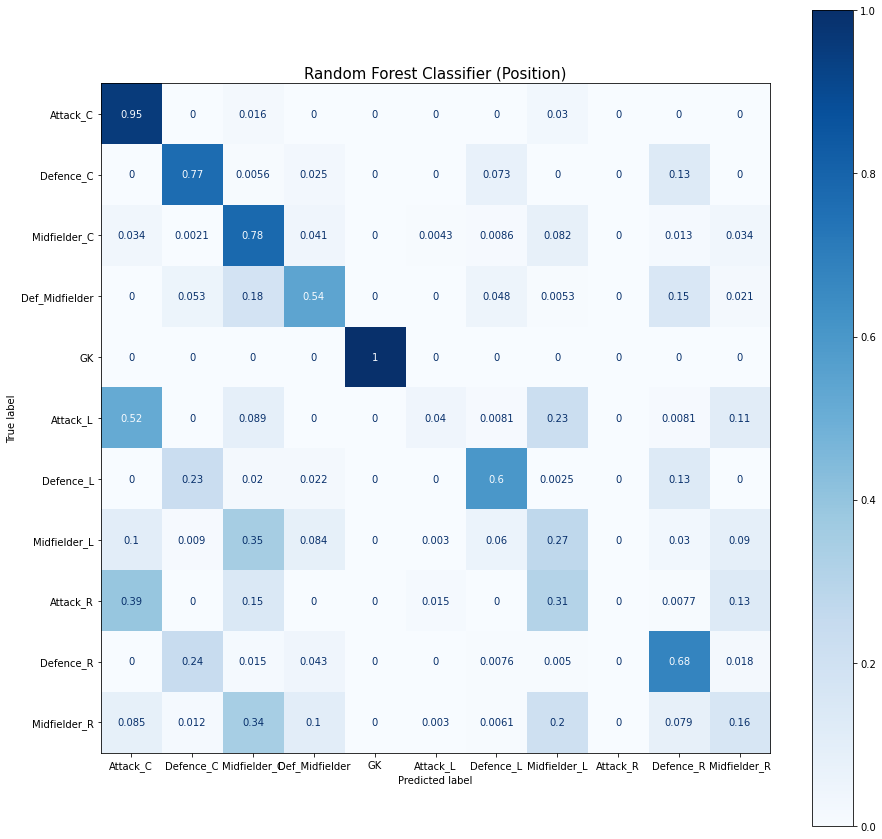

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(80, 200),
  'randomforestclassifier__max_depth' : randint(5,15),
  'randomforestclassifier__min_samples_leaf' : [5,6],
  'randomforestclassifier__min_samples_split' : randint(5, 10),
  'randomforestclassifier__max_features' : randint(3,6)
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

훈련 f1 score (micro):  0.794481981981982
검증 f1 score (micro):  0.6199324324324325
훈련 f1 score (macro):  0.7295597719364154
검증 f1 score (macro):  0.5005483844837226


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,4,0,2,5,8,9,6,1,7,3
mean_fit_time,2.67824,2.72239,2.26407,1.0503,1.42289,1.83838,2.36888,1.38087,1.21929,0.786119
std_fit_time,0.0118032,0.020094,0.0171475,0.00382171,0.00476249,0.0891917,0.020576,0.0219046,0.00923268,0.0158557
mean_score_time,0.209245,0.21194,0.194962,0.120932,0.154284,0.187687,0.195985,0.129315,0.122253,0.108266
std_score_time,0.00796195,0.00114268,0.01677,0.000860358,0.00449222,0.0278395,0.000503551,0.0047954,0.00624317,0.00504953
param_randomforestclassifier__max_depth,13,12,10,13,13,11,9,7,6,6
param_randomforestclassifier__max_features,5,5,5,3,3,3,5,5,5,3
param_randomforestclassifier__min_samples_leaf,5,5,6,5,6,6,5,5,6,6
param_randomforestclassifier__min_samples_split,7,9,5,7,7,6,8,8,8,9
param_randomforestclassifier__n_estimators,158,170,165,82,116,173,181,125,120,95
params,"{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 11, 'ran...","{'randomforestclassifier__max_depth': 9, 'rand...","{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand..."


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   41.4s finished


                 precision    recall  f1-score   support

 central_attack       0.69      0.95      0.80       430
central_defence       0.57      0.77      0.66       356
 central_middle       0.53      0.77      0.63       466
 defence_middle       0.48      0.56      0.51       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.50      0.05      0.09       124
   left_defence       0.78      0.60      0.68       408
    left_middle       0.29      0.23      0.26       334
   right_attack       0.25      0.01      0.01       130
  right_defence       0.62      0.69      0.65       397
   right_middle       0.32      0.16      0.22       328

       accuracy                           0.62      3552
      macro avg       0.55      0.53      0.50      3552
   weighted avg       0.59      0.62      0.58      3552



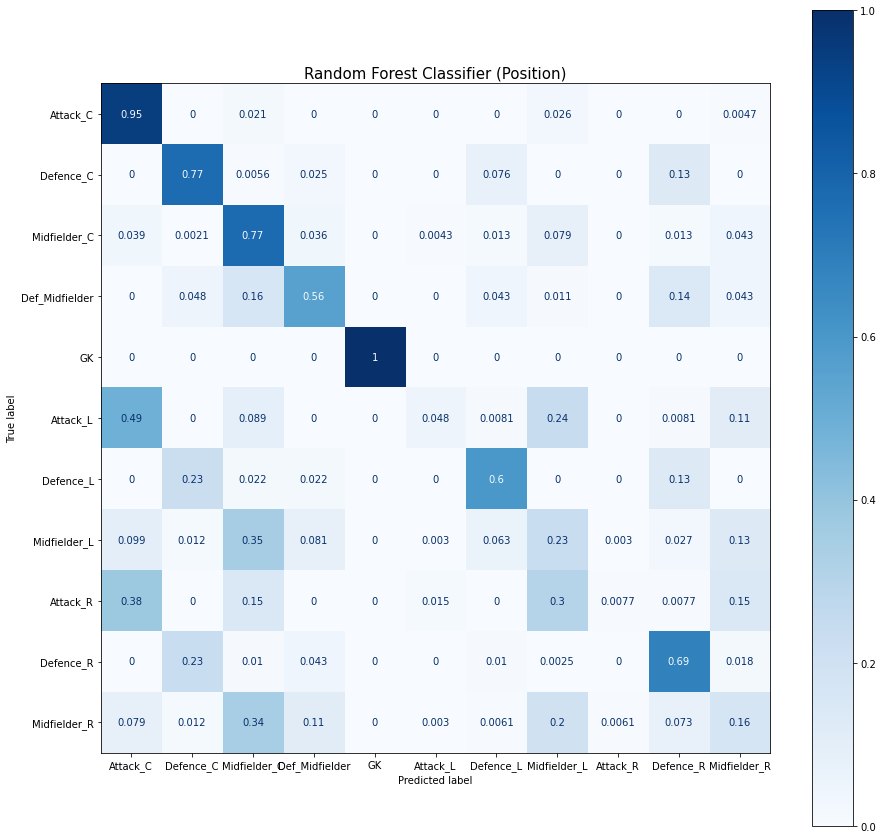

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'randomforestclassifier__n_estimators' : randint(100, 200),
  'randomforestclassifier__max_depth' : randint(10,14),
  'randomforestclassifier__min_samples_leaf' : randint(5,10),
  'randomforestclassifier__min_samples_split' : randint(7, 10),
  'randomforestclassifier__max_features' : randint(3,8)
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    RandomForestClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=12, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.7972034534534534
검증 f1 score (micro):  0.6168355855855856
훈련 f1 score (macro):  0.7362913097073078
검증 f1 score (macro):  0.5006547846475834


,4,3,6,0,8,9,1,11,5,10,2,7
mean_fit_time,2.25663,3.32254,2.00207,2.47226,2.74363,1.7642,2.07098,1.91155,1.28376,1.46217,1.68715,1.23134
std_fit_time,0.0114245,0.0221414,0.0187751,0.0170891,0.0326111,0.0124046,0.00803497,0.231613,0.0207605,0.0133461,0.00219097,0.00351877
mean_score_time,0.154674,0.203939,0.143445,0.186621,0.197994,0.163612,0.1916,0.195672,0.142073,0.156708,0.161971,0.152022
std_score_time,0.00205863,0.00508196,0.00338612,0.0122124,0.0119954,0.00250723,0.0078675,0.0256622,0.000989118,0.00323707,0.00116024,0.00378999
param_randomforestclassifier__max_depth,13,12,12,13,12,12,12,13,12,13,10,11
param_randomforestclassifier__max_features,6,7,6,6,6,4,4,3,3,3,4,3
param_randomforestclassifier__min_samples_leaf,5,6,6,8,5,8,9,6,6,9,9,7
param_randomforestclassifier__min_samples_split,7,9,8,7,8,9,9,8,7,8,7,8
param_randomforestclassifier__n_estimators,117,167,108,137,148,129,156,173,106,123,138,107
params,"{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 12, 'ran...","{'randomforestclassifier__max_depth': 13, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 11, 'ran..."


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.5min finished


                 precision    recall  f1-score   support

 central_attack       0.71      0.93      0.80       430
central_defence       0.59      0.73      0.65       356
 central_middle       0.56      0.78      0.65       466
 defence_middle       0.51      0.59      0.55       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.31      0.09      0.14       124
   left_defence       0.77      0.60      0.68       408
    left_middle       0.27      0.22      0.24       334
   right_attack       0.26      0.07      0.11       130
  right_defence       0.64      0.67      0.66       397
   right_middle       0.35      0.23      0.28       328

       accuracy                           0.62      3552
      macro avg       0.54      0.54      0.52      3552
   weighted avg       0.59      0.62      0.60      3552



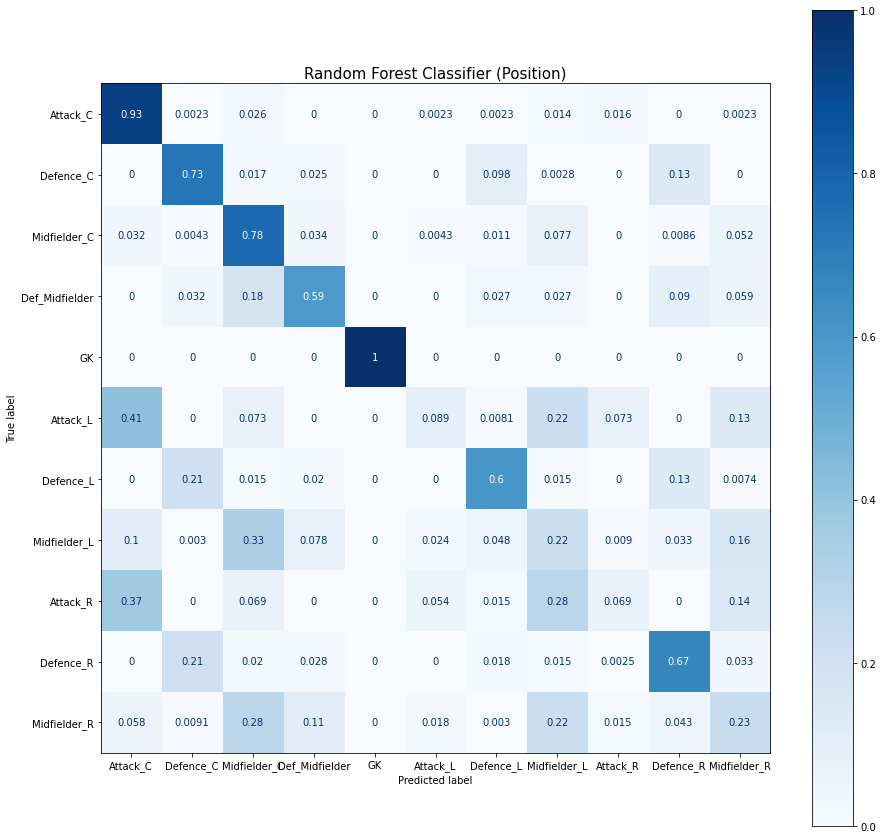

In [ ]:
# Modeling

dists = { # Randomized Classifier Parameter
  'xgbclassifier__n_estimators' : randint(130,180),
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=3, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.725882132132132
검증 f1 score (micro):  0.6210585585585585
훈련 f1 score (macro):  0.658184344112774
검증 f1 score (macro):  0.5232417088040066


,0,2,1
mean_fit_time,42.202,39.9137,47.6948
std_fit_time,0.0688809,6.52594,0.397813
mean_score_time,0.53023,0.43989,0.556827
std_score_time,0.0389685,0.0873823,0.0111385
param_xgbclassifier__n_estimators,158,170,179
params,{'xgbclassifier__n_estimators': 158},{'xgbclassifier__n_estimators': 170},{'xgbclassifier__n_estimators': 179}
split0_test_score,0.64161,0.642173,0.640203
split1_test_score,0.629505,0.627534,0.626971
split2_test_score,0.629223,0.630349,0.632038
mean_test_score,0.633446,0.633352,0.633071


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.4min finished


                 precision    recall  f1-score   support

 central_attack       0.70      0.93      0.80       430
central_defence       0.59      0.73      0.65       356
 central_middle       0.56      0.78      0.65       466
 defence_middle       0.50      0.57      0.53       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.30      0.08      0.13       124
   left_defence       0.77      0.61      0.68       408
    left_middle       0.27      0.22      0.24       334
   right_attack       0.26      0.07      0.11       130
  right_defence       0.64      0.67      0.66       397
   right_middle       0.35      0.24      0.28       328

       accuracy                           0.62      3552
      macro avg       0.54      0.54      0.52      3552
   weighted avg       0.59      0.62      0.60      3552



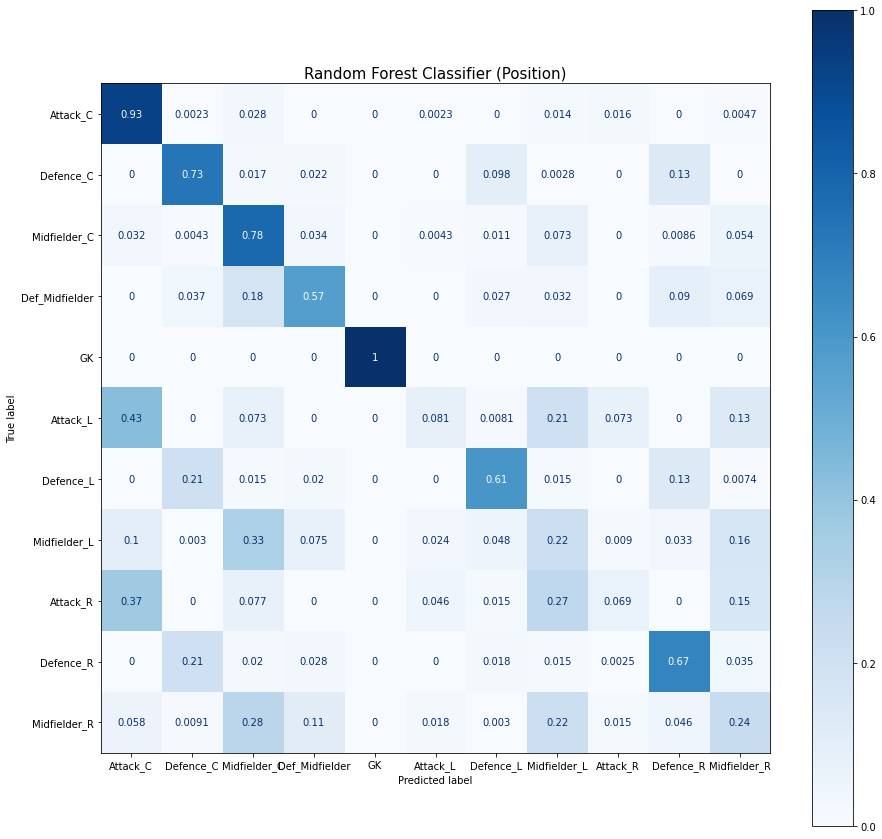

In [ ]:
dists = { # Randomized Classifier Parameter
  'xgbclassifier__n_estimators' : randint(150,180),
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=3, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('Random Forest Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.7305743243243245
검증 f1 score (micro):  0.620777027027027
훈련 f1 score (macro):  0.6641054391951062
검증 f1 score (macro):  0.5216712543809618


,2,1,0
mean_fit_time,37.3888,45.2041,44.4593
std_fit_time,7.20633,0.165439,0.174708
mean_score_time,0.428754,0.538629,0.539461
std_score_time,0.0793933,0.00543682,0.0179369
param_xgbclassifier__n_estimators,164,175,171
params,{'xgbclassifier__n_estimators': 164},{'xgbclassifier__n_estimators': 175},{'xgbclassifier__n_estimators': 171}
split0_test_score,0.641892,0.641329,0.641329
split1_test_score,0.627534,0.627534,0.626408
split2_test_score,0.630912,0.630912,0.630631
mean_test_score,0.633446,0.633258,0.632789


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.4min finished


                 precision    recall  f1-score   support

 central_attack       0.70      0.93      0.80       430
central_defence       0.59      0.73      0.65       356
 central_middle       0.56      0.78      0.65       466
 defence_middle       0.50      0.57      0.53       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.33      0.09      0.14       124
   left_defence       0.77      0.60      0.67       408
    left_middle       0.27      0.21      0.24       334
   right_attack       0.27      0.07      0.11       130
  right_defence       0.64      0.67      0.66       397
   right_middle       0.34      0.23      0.28       328

       accuracy                           0.62      3552
      macro avg       0.54      0.54      0.52      3552
   weighted avg       0.59      0.62      0.59      3552



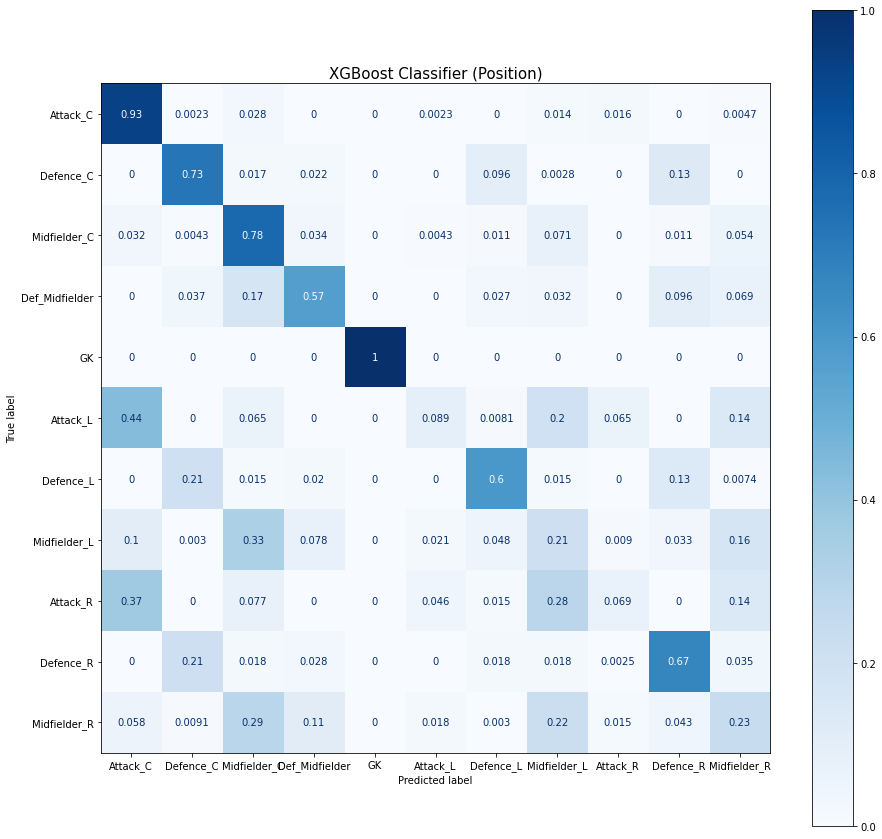

In [ ]:
dists = { # Randomized Classifier Parameter
  'xgbclassifier__n_estimators' : randint(160,178),
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2)
)

clf = RandomizedSearchCV( # RamdommizedSearchCV
    pipe, 
    param_distributions=dists, 
    n_iter=3, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('XGBoost Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.7317942942942943
검증 f1 score (micro):  0.6196509009009009
훈련 f1 score (macro):  0.6665750748768692
검증 f1 score (macro):  0.5213994516962651


,0,1,2
mean_fit_time,42.8384,44.6926,37.8177
std_fit_time,0.0606448,0.384669,6.65436
mean_score_time,0.57346,0.54057,0.439455
std_score_time,0.051744,0.0172205,0.0872873
param_xgbclassifier__n_estimators,167,177,168
params,{'xgbclassifier__n_estimators': 167},{'xgbclassifier__n_estimators': 177},{'xgbclassifier__n_estimators': 168}
split0_test_score,0.642173,0.641329,0.641892
split1_test_score,0.626971,0.626689,0.626126
split2_test_score,0.630912,0.630912,0.630912
mean_test_score,0.633352,0.632977,0.632977


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.8min finished


                 precision    recall  f1-score   support

 central_attack       0.70      0.93      0.80       430
central_defence       0.59      0.74      0.65       356
 central_middle       0.56      0.78      0.65       466
 defence_middle       0.51      0.59      0.54       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.33      0.09      0.14       124
   left_defence       0.78      0.60      0.68       408
    left_middle       0.27      0.22      0.24       334
   right_attack       0.26      0.07      0.11       130
  right_defence       0.64      0.67      0.66       397
   right_middle       0.34      0.23      0.28       328

       accuracy                           0.62      3552
      macro avg       0.54      0.54      0.52      3552
   weighted avg       0.59      0.62      0.60      3552



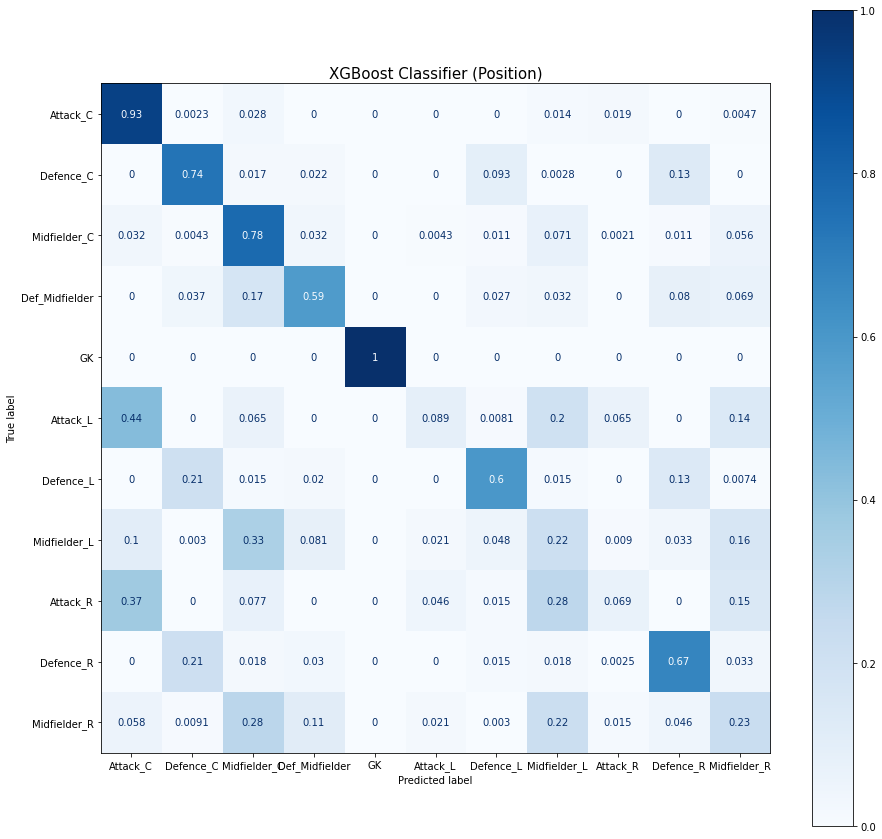

In [ ]:
param = { # Randomized Classifier Parameter
  'xgbclassifier__n_estimators' : (166,169,171,174,175,178),
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2)
)

clf = GridSearchCV( # RamdommizedSearchCV
    pipe, 
    param_grid=param, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('XGBoost Classifier (Position)', fontsize=15);

In [ ]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.7329204204204204
검증 f1 score (micro):  0.620777027027027
훈련 f1 score (macro):  0.6676560379390932
검증 f1 score (macro):  0.522790862828751


,1,0,5,4,3,2
mean_fit_time,43.9853,43.3477,45.4652,45.1584,45.0394,44.8417
std_fit_time,0.254394,0.156462,0.511678,0.0533761,0.166151,0.240237
mean_score_time,0.504935,0.534386,0.484058,0.531353,0.527189,0.520296
std_score_time,0.00636063,0.0308766,0.10176,0.00512134,0.00936126,0.00338597
param_xgbclassifier__n_estimators,169,166,178,175,174,171
params,{'xgbclassifier__n_estimators': 169},{'xgbclassifier__n_estimators': 166},{'xgbclassifier__n_estimators': 178},{'xgbclassifier__n_estimators': 175},{'xgbclassifier__n_estimators': 174},{'xgbclassifier__n_estimators': 171}
split0_test_score,0.6433,0.642736,0.640766,0.641329,0.64161,0.641329
split1_test_score,0.627534,0.626689,0.627534,0.627534,0.627252,0.626408
split2_test_score,0.631194,0.631757,0.631757,0.630912,0.629786,0.630631
mean_test_score,0.634009,0.633727,0.633352,0.633258,0.632883,0.632789


In [ ]:
pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2, n_estmators=166)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

 central_attack       0.71      0.92      0.80       573
central_defence       0.62      0.76      0.68       474
 central_middle       0.55      0.80      0.65       622
 defence_middle       0.50      0.51      0.51       250
     goalkeeper       1.00      1.00      1.00       521
    left_attack       0.24      0.05      0.09       166
   left_defence       0.79      0.70      0.74       544
    left_middle       0.28      0.23      0.25       446
   right_attack       0.20      0.05      0.08       173
  right_defence       0.67      0.69      0.68       529
   right_middle       0.28      0.17      0.21       438

       accuracy                           0.63      4736
      macro avg       0.53      0.53      0.52      4736
   weighted avg       0.59      0.63      0.60      4736



# Permutation importances
<aside>

###💡 **5) 머신러닝 모델 해석**

프로젝트에서 가장 중요하다고 볼 수 있는 부분 입니다. 우리는 SHAP, PDP 등을 통해서 모델이 관측치를 어떤 특성을 활용했거나, 어떤 특성이 타겟에 영향을 끼쳤는지 등을 해석하는 방법에 대해서 배웠습니다.
여러분의 프로젝트에도 이러한 해석 방법을 활용해 머신러닝 모델을 비전문가라도 조금 더 쉽게 이해하고 접근할 수 있도록 해주셔야 합니다.

- PDP, SHAP을 활용하여 최종 모델을 설명합니다
- 시각화는 "설명"이 제일 중요합니다.

### **태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.**

1. 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
2. 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

train_features_transform
</aside>

In [12]:
!pip install eli5

     |████████████████████████████████| 106 kB 6.4 MB/s 


In [13]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean')
                 )),
                 ('clf',  XGBClassifier(random_state=2, n_estmators=166))
],verbose=1)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  25.2s


In [14]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['clf'],
    scoring='accuracy',
    n_iter=5,
    random_state=2
)

X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)
permuter.fit(X_test_transformed, y_test);

feature_names = train_features_transform.tolist() #Xval의 컬럼 *리스트화*
pd.Series(permuter.feature_importances_, feature_names).sort_values()

physic                       -0.002534
LDM_value                    -0.001900
passing                      -0.001689
skill_fk_accuracy            -0.001309
power_jumping                -0.001182
                                ...   
defending                     0.029941
attacking_heading_accuracy    0.035853
defending_sliding_tackle      0.038978
preferred_foot_Right          0.077956
skill_moves                   0.156926
Length: 106, dtype: float64

In [15]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1569 ± 0.0038,skill_moves
0.0780 ± 0.0049,preferred_foot_Right
0.0390 ± 0.0031,defending_sliding_tackle
0.0359 ± 0.0046,attacking_heading_accuracy
0.0299 ± 0.0038,defending
0.0275 ± 0.0059,attacking_crossing
0.0273 ± 0.0059,mentality_vision
0.0242 ± 0.0070,skill_long_passing
0.0237 ± 0.0023,overall
0.0171 ± 0.0023,dribbling


In [17]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

minimum_importance = 0.000 # 최소 중요도 (최소 이정도 이상은 넘어야 한다.)
mask = permuter.feature_importances_ > minimum_importance
features = train_features_transform[mask]

X_train_selected = enc_train[features]
X_val_selected = enc_val[features]
X_test_selected = enc_test[features]

print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 전: (10656, 102) (3552, 102)
특성 삭제 후: (10656, 48) (3552, 48)


In [20]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
#                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean')
                 )),
                 ('clf',  XGBClassifier(random_state=2, n_estmators=166))
],verbose=1)

pipe.fit(X_train_selected, y_train)
y_pred = pipe.predict(X_val_selected)

y_train_pred = pipe.predict(X_train_selected)

print(classification_report(y_val, y_pred))

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_pred, average='macro'))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.7s
                 precision    recall  f1-score   support

 central_attack       0.70      0.94      0.80       430
central_defence       0.59      0.73      0.65       356
 central_middle       0.55      0.80      0.66       466
 defence_middle       0.49      0.52      0.50       188
     goalkeeper       1.00      1.00      1.00       391
    left_attack       0.36      0.10      0.16       124
   left_defence       0.76      0.62      0.68       408
    left_middle       0.28      0.21      0.24       334
   right_attack       0.19      0.03      0.05       130
  right_defence       0.62      0.67      0.65       397
   right_middle       0.34      0.21      0.26       328

       accuracy                           0.62      3552
      macro avg       0.54      0.53      0.51      3552
   weighted avg       0.59      0.62      0.59      3552



                 precision    recall  f1-score   support

 central_attack       0.72      0.92      0.81       573
central_defence       0.62      0.75      0.68       474
 central_middle       0.56      0.81      0.66       622
 defence_middle       0.51      0.52      0.52       250
     goalkeeper       1.00      1.00      1.00       521
    left_attack       0.22      0.07      0.10       166
   left_defence       0.79      0.70      0.74       544
    left_middle       0.31      0.24      0.27       446
   right_attack       0.28      0.06      0.10       173
  right_defence       0.67      0.70      0.68       529
   right_middle       0.31      0.18      0.23       438

       accuracy                           0.63      4736
      macro avg       0.54      0.54      0.53      4736
   weighted avg       0.60      0.63      0.61      4736

훈련 f1 score (micro):  0.6831831831831832
테스트 f1 score (micro):  0.6347128378378378
훈련 f1 score (macro):  0.5952402574769328
테스트 f1 score (macr

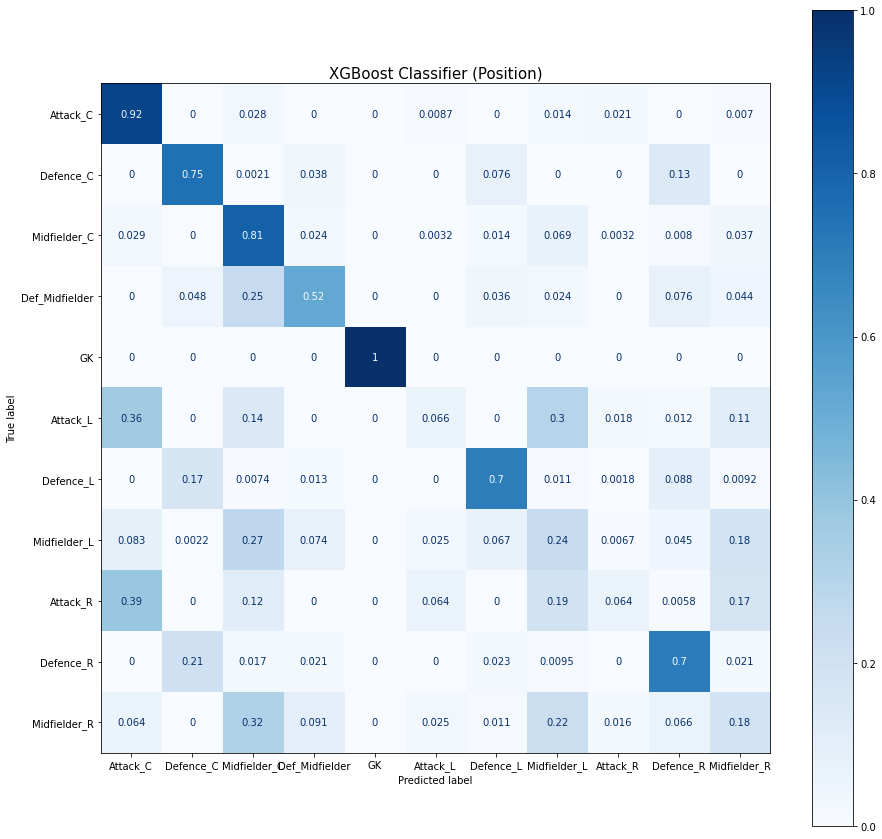

In [22]:
y_pred = pipe.predict(X_test_selected)

y_train_pred = pipe.predict(X_train_selected)

print(classification_report(y_test, y_pred))

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('테스트 f1 score (micro): ', f1_score(y_test, y_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('테스트 f1 score (macro): ', f1_score(y_test, y_pred, average='macro'))
print('---------------')
print('훈련 accuracy (micro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (micro): ', accuracy_score(y_test, y_pred))

print('훈련 accuracy (macro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (macro): ', accuracy_score(y_test, y_pred))

# 시각화
label = ['Attack_C', 'Defence_C', 'Midfielder_C', 'Def_Midfielder', 'GK',
         'Attack_L', 'Defence_L', 'Midfielder_L', 'Attack_R', 'Defence_R', 'Midfielder_R']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(pipe, 
                              X_test_selected, y_test,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)

plt.title('XGBoost Classifier (Position)', fontsize=15);

In [23]:
!pip install shap

     |████████████████████████████████| 371 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509236 sha256=053733a841219199d99f51cf892238594a4967f577304d06a6127f7ef3fdd9c9
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [47]:
enc = OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

clf = XGBClassifier(random_state=2, n_estmators=166)

X_train_transformed = enc.fit_transform(X_train)
X_test_transformed = enc.transform(X_test)
X_train_imputed = imp.fit_transform(X_train_transformed)
X_test_imputed = imp.transform(X_test_transformed)

clf.fit(X_train_imputed, y_train)
y_pred = clf.predict(X_test_imputed)

In [43]:
dataset = pd.DataFrame(X_test_transformed)

In [44]:
 dataset.columns = enc_test.columns

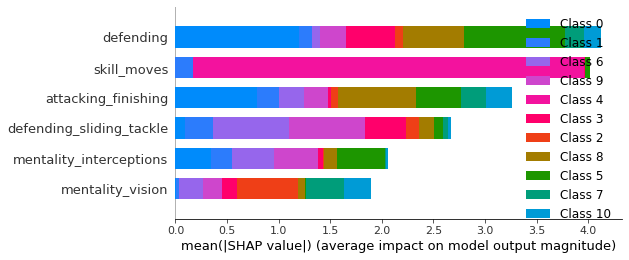

In [53]:
import shap

explainer = shap.TreeExplainer(clf) 
shap.initjs() #인라인 자바스크립트

shap_values = explainer.shap_values(dataset.iloc[:200])
shap.summary_plot(shap_values, dataset.iloc[:200], plot_type='bar', max_display=6)

In [37]:
X_train_selected

,preferred_foot_Right,work_rate_Attaking,work_rate_defensive,pace,shooting,dribbling,defending,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,skill_long_passing,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_stamina,power_long_shots,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_reflexes,LS_grow,LF_value,LAM_value,LAM_grow,LM_value,LM_grow,LCM_value,LCM_grow,LWB_grow,LDM_grow,LB_grow,LCB_value,LCB_grow,age,height_cm,overall,potential,weak_foot,skill_moves
4574,1,2,2,67.0,63.0,68.0,69.0,63,55,62,74,71,64,69,54,68,61,73,67,76,63,40,75,49,60,72,71,10,10,2,65,67,2,66,2,69,2,2,2,2,67,2,22,183,70,80,3,3
2048,1,3,1,79.0,74.0,77.0,33.0,65,75,63,71,61,80,79,81,73,83,75,74,74,27,77,63,71,77,29,31,11,12,2,74,73,2,73,2,66,2,2,2,2,47,2,21,176,74,85,2,3
8673,1,2,2,68.0,55.0,73.0,61.0,58,54,48,64,64,69,68,80,63,77,61,84,54,65,59,68,48,62,60,58,8,14,2,64,66,2,66,2,66,2,2,2,2,61,2,24,178,66,73,4,3
17234,1,2,2,54.0,34.0,42.0,56.0,31,31,54,46,41,55,54,53,52,58,43,48,35,57,33,34,28,53,56,54,14,6,2,41,41,2,41,2,43,2,2,2,2,56,2,19,185,56,69,3,2
16817,1,2,2,82.0,38.0,56.0,48.0,53,53,36,54,47,81,83,68,51,87,22,62,23,48,55,39,33,50,50,51,6,14,2,52,52,2,56,2,49,2,2,2,2,50,2,20,168,57,69,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,1,3,1,84.0,71.0,82.0,34.0,78,67,60,75,67,83,84,85,78,72,79,73,75,31,77,78,62,70,32,31,13,8,3,78,78,1,78,1,72,3,3,3,3,49,3,30,176,79,79,3,4
13795,1,3,2,74.0,57.0,62.0,53.0,63,53,55,67,59,73,74,58,58,63,68,71,54,59,63,62,60,60,58,55,11,6,1,62,62,0,64,0,62,0,1,2,1,58,2,27,182,62,62,3,3
3926,0,3,2,74.0,72.0,71.0,41.0,68,75,43,67,65,75,73,74,65,71,67,66,75,41,68,75,69,67,46,35,12,8,2,70,71,2,70,2,67,2,2,2,2,44,2,24,173,71,77,3,3
8083,0,3,1,76.0,59.0,71.0,46.0,70,57,52,57,63,81,72,80,62,82,58,53,65,52,61,61,55,52,52,48,9,13,2,64,65,2,66,1,61,2,2,2,2,52,2,32,177,67,67,3,3


# 4 Positions

In [69]:
df = pd.read_csv('/content/cls_df.csv')
df = df.iloc[:,1:]

In [70]:
df

,preferred_foot,work_rate_Attaking,work_rate_defensive,body_type,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,...,RAM_value,RAM_grow,LM_value,LM_grow,LCM_value,LCM_grow,CM_value,CM_grow,RCM_value,RCM_grow,RM_value,RM_grow,LWB_value,LWB_grow,LDM_value,LDM_grow,CDM_value,CDM_grow,RDM_value,RDM_grow,RWB_value,RWB_grow,LB_value,LB_grow,LCB_value,LCB_grow,CB_value,CB_grow,RCB_value,RCB_grow,RB_value,RB_grow,age,height_cm,weight_kg,overall,potential,weak_foot,skill_moves,position
0,Left,2,1,Unique,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,35,24,6,11,...,93,0,91,2,87,3,87,3,87,3,91,2,66,3,65,3,65,3,65,3,66,3,62,3,52,3,52,3,52,3,62,3,33,170,72,93,93,4,4,Middle
1,Right,3,1,Unique,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,32,24,7,11,...,88,3,88,3,81,3,81,3,81,3,88,3,65,3,61,3,61,3,61,3,65,3,61,3,54,3,54,3,54,3,61,3,35,187,83,92,92,4,5,Attack
2,Right,2,2,Normal,NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,12,18,87,92,...,38,3,35,3,38,3,38,3,38,3,35,3,32,3,36,3,36,3,36,3,32,3,32,3,33,3,33,3,33,3,32,3,27,188,87,91,93,3,1,Goalkeeper
3,Right,3,2,Normal,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,42,19,15,6,...,85,3,83,3,79,3,79,3,79,3,83,3,64,3,65,3,65,3,65,3,64,3,61,3,60,3,60,3,60,3,61,3,31,184,80,91,91,4,4,Attack
4,Right,3,2,Unique,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,30,29,9,9,...,90,1,90,1,83,3,83,3,83,3,90,1,67,3,62,3,62,3,62,3,67,3,62,3,49,3,49,3,49,3,62,3,28,175,68,91,91,5,5,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18939,Right,2,2,Normal,63.0,37.0,50.0,47.0,41.0,50.0,45,37,43,55,27,44,35,35,53,46,64,62,53,51,71,43,57,40,51,36,57,41,31,49,39,36,39,54,10,9,...,47,2,48,2,47,2,47,2,47,2,48,2,47,2,47,2,47,2,47,2,47,2,47,2,46,2,46,2,46,2,47,2,24,176,73,47,52,2,2,Middle
18940,Right,1,1,Normal,58.0,23.0,26.0,27.0,50.0,48.0,23,16,45,31,26,19,21,22,25,24,60,56,45,48,70,35,65,55,45,23,44,50,25,25,35,40,56,47,12,13,...,29,2,31,2,32,2,32,2,32,2,31,2,42,2,41,2,41,2,41,2,42,2,45,2,47,2,47,2,47,2,45,2,21,177,70,47,52,2,2,Defence
18941,Right,1,2,Normal,51.0,25.0,29.0,36.0,45.0,55.0,20,20,46,40,22,35,20,25,25,30,54,49,40,45,57,35,69,58,55,22,46,45,25,25,35,40,55,45,12,9,...,33,2,35,2,35,2,35,2,35,2,35,2,42,2,42,2,42,2,42,2,42,2,44,2,47,2,47,2,47,2,44,2,20,185,74,47,51,2,2,Defence
18942,Right,1,1,Lean,61.0,35.0,48.0,48.0,44.0,58.0,38,32,45,56,32,45,35,35,54,48,62,60,59,51,53,45,56,48,63,33,56,40,31,45,42,43,49,45,15,7,...,47,2,47,2,47,2,47,2,47,2,47,2,47,2,49,2,49,2,49,2,47,2,47,2,49,2,49,2,49,2,47,2,23,186,80,47,51,2,2,Middle


In [71]:
# 공격수
df.loc[df['position']=='ST', ['position']] = 'Attack'
df.loc[df['position']=='LS', ['position']] = 'Attack'
df.loc[df['position']=='RS', ['position']] = 'Attack'
df.loc[df['position']=='RF', ['position']] = 'Attack'
df.loc[df['position']=='LF', ['position']] = 'Attack'
df.loc[df['position']=='CF', ['position']] = 'Attack'
df.loc[df['position']=='LW', ['position']] = 'Attack'
df.loc[df['position']=='RW', ['position']] = 'Attack'

# 골기퍼
df.loc[df['position']=='GK', ['position']] = 'Goalkeeper'

# 미드필더
df.loc[df['position']=='CAM', ['position']] = 'Middle'
df.loc[df['position']=='LAM', ['position']] = 'Middle'
df.loc[df['position']=='RAM', ['position']] = 'Middle'
df.loc[df['position']=='AM', ['position']] = 'Middle'
df.loc[df['position']=='LM', ['position']] = 'Middle'
df.loc[df['position']=='RM', ['position']] = 'Middle'
df.loc[df['position']=='CM', ['position']] = 'Middle'
df.loc[df['position']=='LCM', ['position']] = 'Middle'
df.loc[df['position']=='RCM', ['position']] = 'Middle'
df.loc[df['position']=='CDM', ['position']] = 'Middle'
df.loc[df['position']=='LDM', ['position']] = 'Middle'
df.loc[df['position']=='RDM', ['position']] = 'Middle'

# 수비수
df.loc[df['position']=='LWB', ['position']] = 'Defence'
df.loc[df['position']=='RWB', ['position']] = 'Defence'
df.loc[df['position']=='CB', ['position']] = 'Defence'
df.loc[df['position']=='LCB', ['position']] = 'Defence'
df.loc[df['position']=='RCB', ['position']] = 'Defence'
df.loc[df['position']=='LB', ['position']] = 'Defence'
df.loc[df['position']=='RB', ['position']] = 'Defence'

In [72]:
df.to_csv('/content/cls4_df.csv', index=True)

In [75]:
from sklearn.model_selection import train_test_split 

target = 'position'
train, test = train_test_split(df, random_state=2, train_size=.75, stratify=df[target])
train, val = train_test_split(train, random_state=2, train_size=.75, stratify=train[target])
train.shape, val.shape, test.shape

((10656, 103), (3552, 103), (4736, 103))

In [76]:
features = train.columns.drop(target)
X_train = train[features] 
X_val = val[features]
X_test = test[features]
y_train = train[target]
y_val = val[target] 
y_test = test[target]

In [77]:
enc = OneHotEncoder(cols = [
                            'preferred_foot',
                            'body_type'
], use_cat_names=True)

enc_train = enc.fit_transform(X_train)
train_features_transform = enc_train.columns # 인코딩이 완료된 특성을 변수에 담기

enc_val = enc.transform(X_val)
enc_test = enc.transform(X_test)


In [84]:
param = { # Randomized Classifier Parameter
  'xgbclassifier__n_estimators' : (166,169,171,174,175,178),
}


pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2)
)

clf = GridSearchCV( # RamdommizedSearchCV
    pipe, 
    param_grid=param, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))



Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.6min finished


              precision    recall  f1-score   support

      Attack       0.88      0.79      0.83       684
     Defence       0.94      0.94      0.94      1160
  Goalkeeper       1.00      1.00      1.00       391
      Middle       0.84      0.89      0.87      1317

    accuracy                           0.90      3552
   macro avg       0.91      0.90      0.91      3552
weighted avg       0.90      0.90      0.90      3552



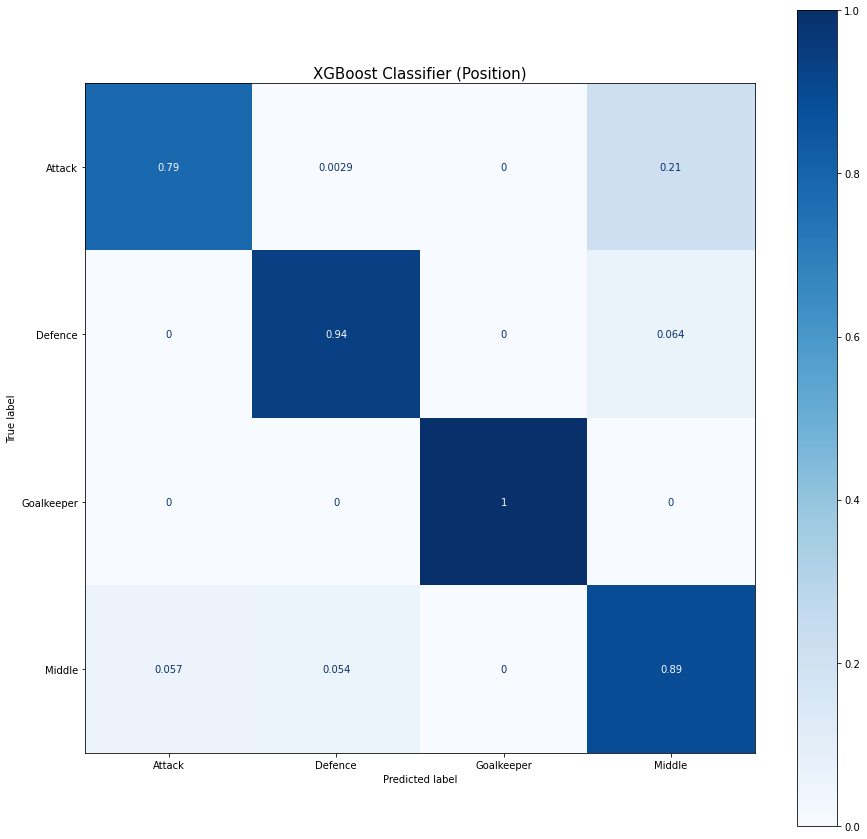

In [85]:
# 시각화
label = ['Attack', 'Defence', 'Goalkeeper','Middle']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('XGBoost Classifier (Position)', fontsize=15);

In [86]:
model = clf.best_estimator_

y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_val_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_val_pred, average='macro'))

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

훈련 f1 score (micro):  0.9240803303303303
검증 f1 score (micro):  0.8966779279279279
훈련 f1 score (macro):  0.9304575081587423
검증 f1 score (macro):  0.9076196750866233


,5,4,2,1,3,0
mean_fit_time,17.6894,17.5867,17.4423,16.9744,17.4544,16.7974
std_fit_time,0.0971595,0.0560749,0.266999,0.0591188,0.143369,0.0510428
mean_score_time,0.165643,0.199512,0.186028,0.181012,0.198131,0.183805
std_score_time,0.0312538,0.0159265,0.00468806,0.00453256,0.011284,0.00136394
param_xgbclassifier__n_estimators,178,175,171,169,174,166
params,{'xgbclassifier__n_estimators': 178},{'xgbclassifier__n_estimators': 175},{'xgbclassifier__n_estimators': 171},{'xgbclassifier__n_estimators': 169},{'xgbclassifier__n_estimators': 174},{'xgbclassifier__n_estimators': 166}
split0_test_score,0.895552,0.893863,0.893863,0.894144,0.893581,0.893863
split1_test_score,0.889358,0.889358,0.889358,0.88964,0.889358,0.888795
split2_test_score,0.895552,0.894989,0.894707,0.893863,0.894707,0.893863
mean_test_score,0.893487,0.892736,0.892643,0.892549,0.892549,0.892173


In [88]:
pipe = make_pipeline( # Modeling Pipeline
    OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    XGBClassifier(random_state=2, n_estmators=178)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Attack       0.85      0.78      0.82       912
     Defence       0.93      0.94      0.93      1547
  Goalkeeper       1.00      1.00      1.00       521
      Middle       0.84      0.87      0.86      1756

    accuracy                           0.89      4736
   macro avg       0.91      0.90      0.90      4736
weighted avg       0.89      0.89      0.89      4736



              precision    recall  f1-score   support

      Attack       0.85      0.78      0.82       912
     Defence       0.93      0.94      0.93      1547
  Goalkeeper       1.00      1.00      1.00       521
      Middle       0.84      0.87      0.86      1756

    accuracy                           0.89      4736
   macro avg       0.91      0.90      0.90      4736
weighted avg       0.89      0.89      0.89      4736

훈련 f1 score (micro):  0.9071884384384385
테스트 f1 score (micro):  0.8897804054054054
훈련 f1 score (macro):  0.9153802819279817
테스트 f1 score (macro):  0.9013674424995571
---------------
훈련 accuracy (micro):  0.9071884384384384
테스트 accuracy (micro):  0.8897804054054054
훈련 accuracy (macro):  0.9071884384384384
테스트 accuracy (macro):  0.8897804054054054


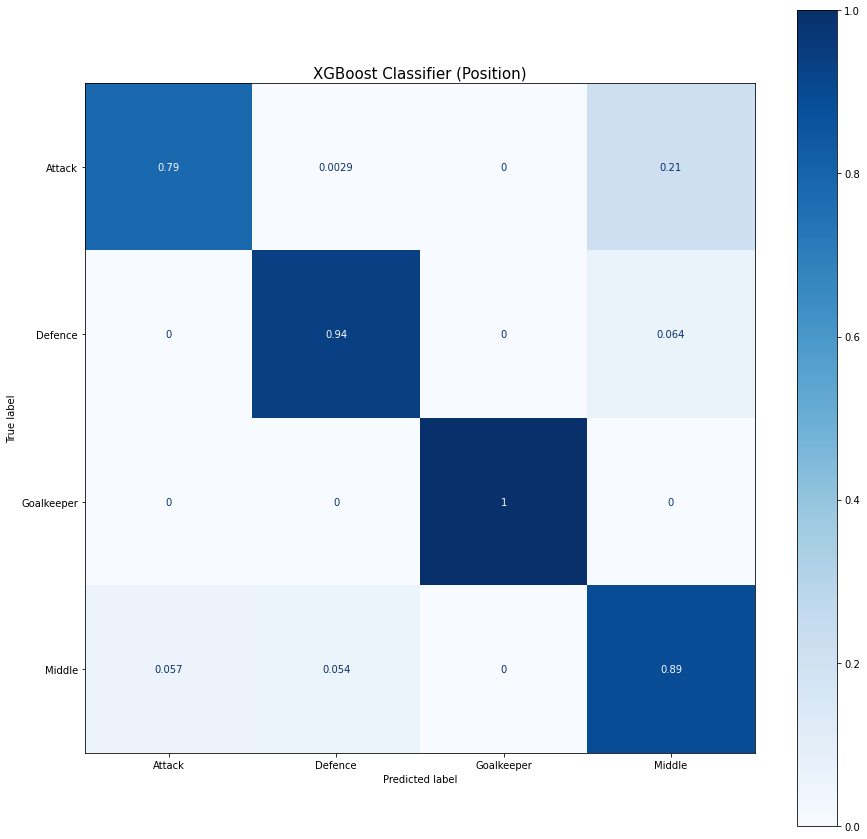

In [91]:
y_pred = pipe.predict(X_test)

y_train_pred = pipe.predict(X_train)

print(classification_report(y_test, y_pred))

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('테스트 f1 score (micro): ', f1_score(y_test, y_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('테스트 f1 score (macro): ', f1_score(y_test, y_pred, average='macro'))
print('---------------')
print('훈련 accuracy (micro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (micro): ', accuracy_score(y_test, y_pred))

print('훈련 accuracy (macro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (macro): ', accuracy_score(y_test, y_pred))


# 시각화
label = ['Attack', 'Defence', 'Goalkeeper','Middle']
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, 
                              X_val, y_val,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)
plt.title('XGBoost Classifier (Position)', fontsize=15);

In [93]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean')
                 )),
                 ('clf',  XGBClassifier(random_state=2, n_estmators=178))
],verbose=1)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   9.0s


In [94]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['clf'],
    scoring='accuracy',
    n_iter=5,
    random_state=2
)

X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)
permuter.fit(X_test_transformed, y_test);

feature_names = train_features_transform.tolist() #Xval의 컬럼 *리스트화*
pd.Series(permuter.feature_importances_, feature_names).sort_values()

shooting                     -0.000676
pace                         -0.000591
power_long_shots             -0.000380
LAM_value                    -0.000253
work_rate_defensive          -0.000253
                                ...   
skill_long_passing            0.028801
mentality_vision              0.032390
attacking_heading_accuracy    0.033446
defending_sliding_tackle      0.037838
skill_moves                   0.183826
Length: 106, dtype: float64

In [95]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1838 ± 0.0018,skill_moves
0.0378 ± 0.0047,defending_sliding_tackle
0.0334 ± 0.0066,attacking_heading_accuracy
0.0324 ± 0.0025,mentality_vision
0.0288 ± 0.0068,skill_long_passing
0.0275 ± 0.0038,attacking_finishing
0.0210 ± 0.0034,attacking_crossing
0.0168 ± 0.0040,defending
0.0048 ± 0.0056,mentality_interceptions
0.0042 ± 0.0022,attacking_short_passing


In [96]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

minimum_importance = 0.000 # 최소 중요도 (최소 이정도 이상은 넘어야 한다.)
mask = permuter.feature_importances_ > minimum_importance
features = train_features_transform[mask]

X_train_selected = enc_train[features]
X_val_selected = enc_val[features]
X_test_selected = enc_test[features]

print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 전: (10656, 102) (3552, 102)
특성 삭제 후: (10656, 49) (3552, 49)


In [97]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(
#                     OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True),
                     SimpleImputer(missing_values=np.nan, strategy='mean')
                 )),
                 ('clf',  XGBClassifier(random_state=2, n_estmators=166))
],verbose=1)

pipe.fit(X_train_selected, y_train)
y_pred = pipe.predict(X_val_selected)

y_train_pred = pipe.predict(X_train_selected)

print(classification_report(y_val, y_pred))

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('검증 f1 score (micro): ', f1_score(y_val, y_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('검증 f1 score (macro): ', f1_score(y_val, y_pred, average='macro'))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   4.8s
              precision    recall  f1-score   support

      Attack       0.89      0.79      0.83       684
     Defence       0.93      0.93      0.93      1160
  Goalkeeper       1.00      1.00      1.00       391
      Middle       0.84      0.89      0.86      1317

    accuracy                           0.90      3552
   macro avg       0.91      0.90      0.91      3552
weighted avg       0.90      0.90      0.90      3552

훈련 f1 score (micro):  0.9049361861861862
검증 f1 score (micro):  0.8952702702702703
훈련 f1 score (macro):  0.9138712078596019
검증 f1 score (macro):  0.9071477578970077


              precision    recall  f1-score   support

      Attack       0.86      0.78      0.82       912
     Defence       0.93      0.94      0.93      1547
  Goalkeeper       1.00      1.00      1.00       521
      Middle       0.84      0.87      0.86      1756

    accuracy                           0.89      4736
   macro avg       0.91      0.90      0.90      4736
weighted avg       0.89      0.89      0.89      4736

훈련 f1 score (micro):  0.9049361861861862
테스트 f1 score (micro):  0.8904138513513513
훈련 f1 score (macro):  0.9138712078596019
테스트 f1 score (macro):  0.9015873446919267
---------------
훈련 accuracy (micro):  0.9049361861861862
테스트 accuracy (micro):  0.8904138513513513
훈련 accuracy (macro):  0.9049361861861862
테스트 accuracy (macro):  0.8904138513513513


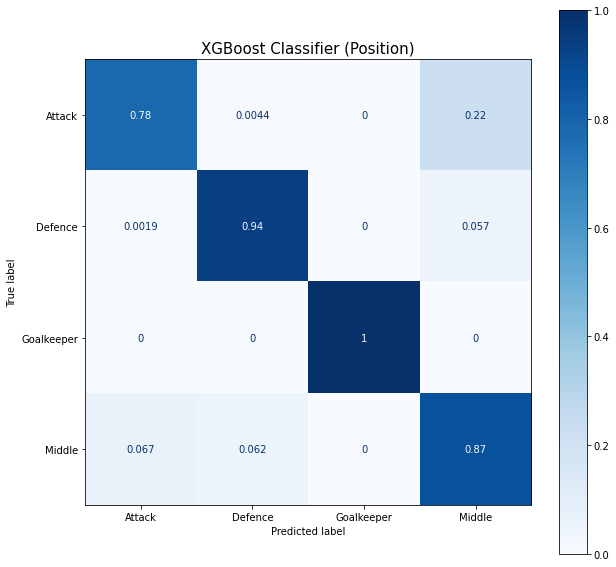

In [99]:
y_pred = pipe.predict(X_test_selected)

y_train_pred = pipe.predict(X_train_selected)

print(classification_report(y_test, y_pred))

print('훈련 f1 score (micro): ', f1_score(y_train, y_train_pred, average='micro'))
print('테스트 f1 score (micro): ', f1_score(y_test, y_pred, average='micro'))

print('훈련 f1 score (macro): ', f1_score(y_train, y_train_pred, average='macro'))
print('테스트 f1 score (macro): ', f1_score(y_test, y_pred, average='macro'))
print('---------------')
print('훈련 accuracy (micro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (micro): ', accuracy_score(y_test, y_pred))

print('훈련 accuracy (macro): ', accuracy_score(y_train, y_train_pred))
print('테스트 accuracy (macro): ', accuracy_score(y_test, y_pred))

# 시각화
label = ['Attack', 'Defence', 'Goalkeeper','Middle']
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, 
                              X_test_selected, y_test,
                              display_labels = label,
                              cmap = 'Blues',
                              normalize='true',
                              ax = ax)

plt.title('XGBoost Classifier (Position)', fontsize=15);

In [100]:
enc = OneHotEncoder(cols=['preferred_foot','body_type'], use_cat_names=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

clf = XGBClassifier(random_state=2, n_estmators=166)

X_train_transformed = enc.fit_transform(X_train)
X_test_transformed = enc.transform(X_test)
X_train_imputed = imp.fit_transform(X_train_transformed)
X_test_imputed = imp.transform(X_test_transformed)

clf.fit(X_train_imputed, y_train)
y_pred = clf.predict(X_test_imputed)

In [101]:
dataset = pd.DataFrame(X_test_transformed)

In [102]:
 dataset.columns = enc_test.columns

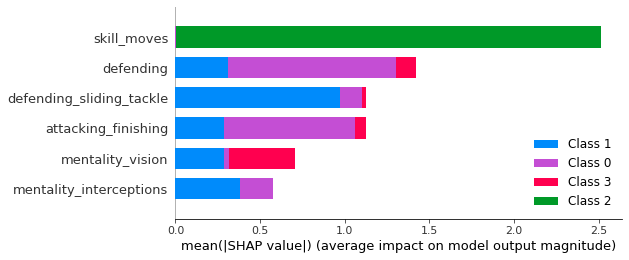

In [104]:
import shap

explainer = shap.TreeExplainer(clf) 
shap.initjs() #인라인 자바스크립트

shap_values = explainer.shap_values(dataset.iloc[:200])
shap.summary_plot(shap_values, dataset.iloc[:200], plot_type='bar', max_display=6)